In [2]:
# --- Імпорт необхідних бібліотек ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
# --- 1. Завантаження та попередній аналіз даних ---
df = pd.read_csv('Student_Performance.csv')

# Перевірка структури даних
print("Розмірність даних:", df.shape)
print("\nПерші 5 рядків:")
print(df.head())
print("\nІнформація про дані:")
print(df.info())
print("\nСтатистичний опис даних:")
print(df.describe())
print("\nПеревірка на пропущені значення:")
print(df.isnull().sum())

Розмірність даних: (10000, 6)

Перші 5 рядків:
   Hours Studied  Previous Scores Extracurricular Activities  Sleep Hours  \
0              7               99                        Yes            9   
1              4               82                         No            4   
2              8               51                        Yes            7   
3              5               52                        Yes            5   
4              7               75                         No            8   

   Sample Question Papers Practiced  Performance Index  
0                                 1               91.0  
1                                 2               65.0  
2                                 2               45.0  
3                                 2               36.0  
4                                 5               66.0  

Інформація про дані:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column        

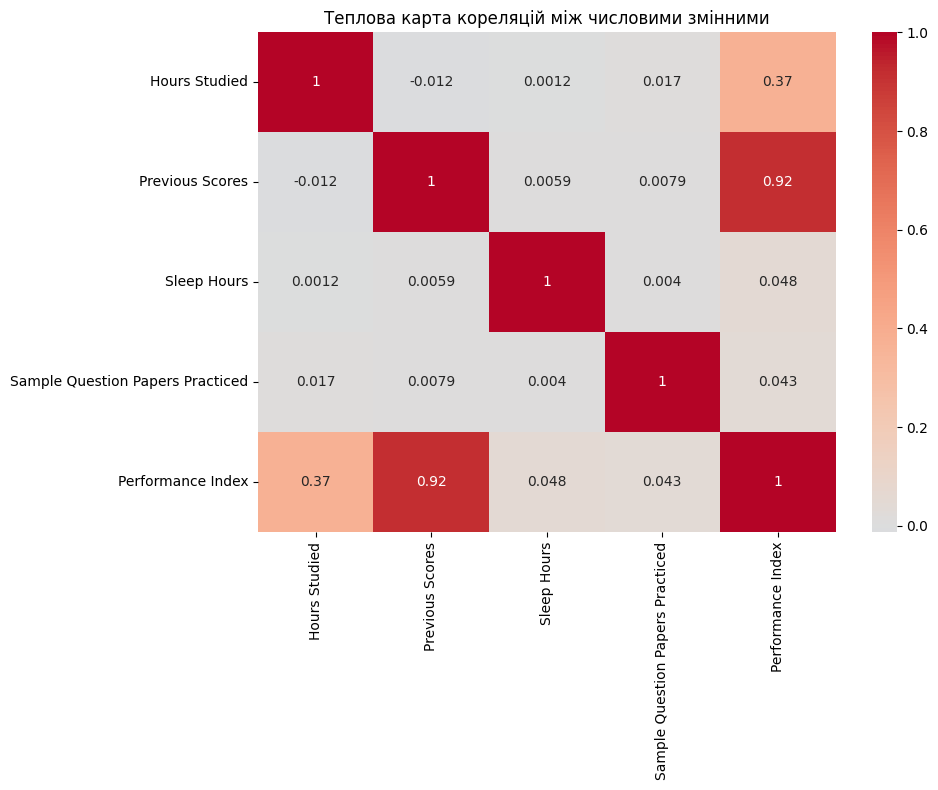

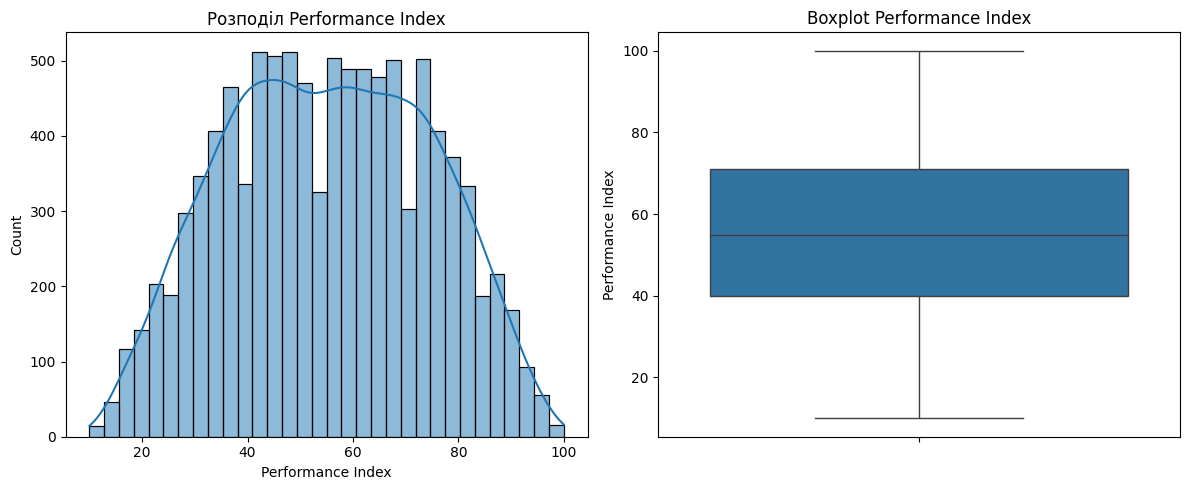

In [4]:
# --- 2. Розвідковий аналіз даних (EDA) ---
# Теплова карта кореляцій
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Теплова карта кореляцій між числовими змінними')
plt.tight_layout()
plt.show()

# Аналіз цільової змінної
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['Performance Index'], kde=True)
plt.title('Розподіл Performance Index')

plt.subplot(1, 2, 2)
sns.boxplot(y=df['Performance Index'])
plt.title('Boxplot Performance Index')
plt.tight_layout()
plt.show()


In [5]:
# --- 3. Підготовка даних ---
# Обробка категоріальної змінної
df['Extracurricular Activities'] = df['Extracurricular Activities'].map({'Yes': 1, 'No': 0})

# Вибір ознак та цільової змінної
X = df.drop('Performance Index', axis=1)
y = df['Performance Index']

# Поділ на тренувальну та тестову вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабування ознак
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Додаємо стовпець одиниць для intercept
X_train_final = np.c_[np.ones(X_train_scaled.shape[0]), X_train_scaled]
X_test_final = np.c_[np.ones(X_test_scaled.shape[0]), X_test_scaled]


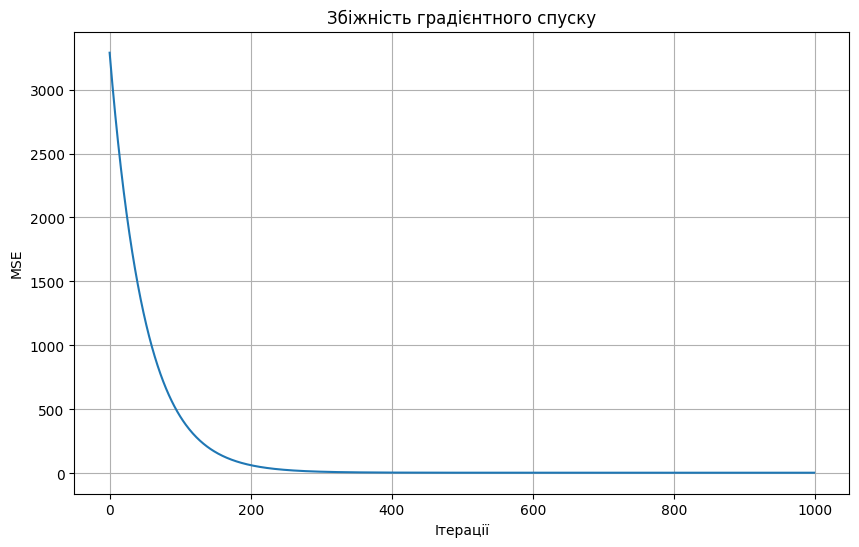

In [6]:
# --- 4. Реалізація градієнтного спуску ---
def compute_cost(X, y, b):
    """Обчислення функції втрат MSE"""
    predictions = X.dot(b)
    errors = predictions - y
    mse = (1 / len(y)) * np.sum(errors ** 2)
    return mse

def gradient_descent(X, y, b, learning_rate, epochs):
    """Реалізація градієнтного спуску"""
    cost_history = []
    m = len(y)
    
    for _ in range(epochs):
        # Обчислення передбачень
        predictions = X.dot(b)

# Обчислення помилки
        errors = predictions - y
        
        # Обчислення градієнта
        gradient = (1 / m) * X.T.dot(errors)
        
        # Оновлення ваг
        b = b - learning_rate * gradient

# Збереження поточного MSE
        cost = compute_cost(X, y, b)
        cost_history.append(cost)
        
    return b, cost_history

# Ініціалізація параметрів
np.random.seed(42)
b_initial = np.random.randn(X_train_final.shape[1])
learning_rate = 0.01
epochs = 1000

# Навчання моделі
b_final, cost_history = gradient_descent(X_train_final, y_train, b_initial, learning_rate, epochs)

# Візуалізація збіжності
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), cost_history)
plt.xlabel('Ітерації')
plt.ylabel('MSE')
plt.title('Збіжність градієнтного спуску')
plt.grid(True)
plt.show()

In [7]:
# --- 5. Оцінка якості моделі ---
# Прогнозування на тестових даних
y_pred = X_test_final.dot(b_final)

# Обчислення метрик
mse_test = np.mean((y_test - y_pred) ** 2)
r2 = 1 - (np.sum((y_test - y_pred) ** 2) / np.sum((y_test - np.mean(y_test)) ** 2))

print("Результати оцінки моделі:")
print(f"MSE на тестовій вибірці: {mse_test:.4f}")
print(f"R² на тестовій вибірці: {r2:.4f}")

# Порівняння з бейзлайном (передбачення середнім)
baseline_pred = np.full_like(y_test, np.mean(y_train))
baseline_mse = np.mean((y_test - baseline_pred) ** 2)
print(f"MSE бейзлайну (середнє значення): {baseline_mse:.4f}")
print(f"Поліпшення над бейзлайном: {((baseline_mse - mse_test) / baseline_mse * 100):.2f}%")

Результати оцінки моделі:
MSE на тестовій вибірці: 4.0825
R² на тестовій вибірці: 0.9890
MSE бейзлайну (середнє значення): 370.7730
Поліпшення над бейзлайном: 98.90%


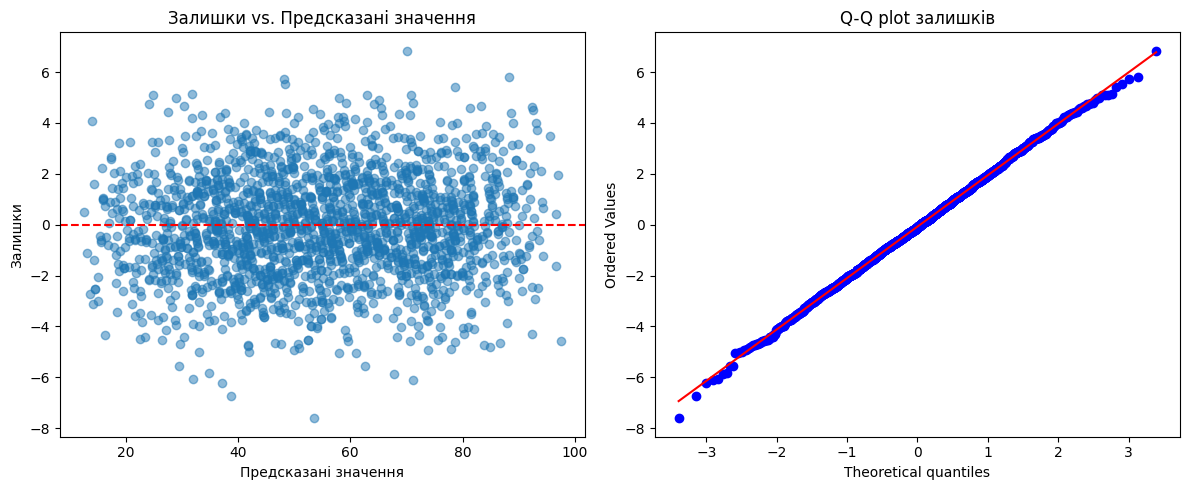

Shapiro-Wilk test: statistic=0.9996, p-value=0.9751

VIF фактори:

Тест Дарбіна-Вотсона: 2.0331

Кількість впливових спостережень (Cook's D > 0.0005): 391


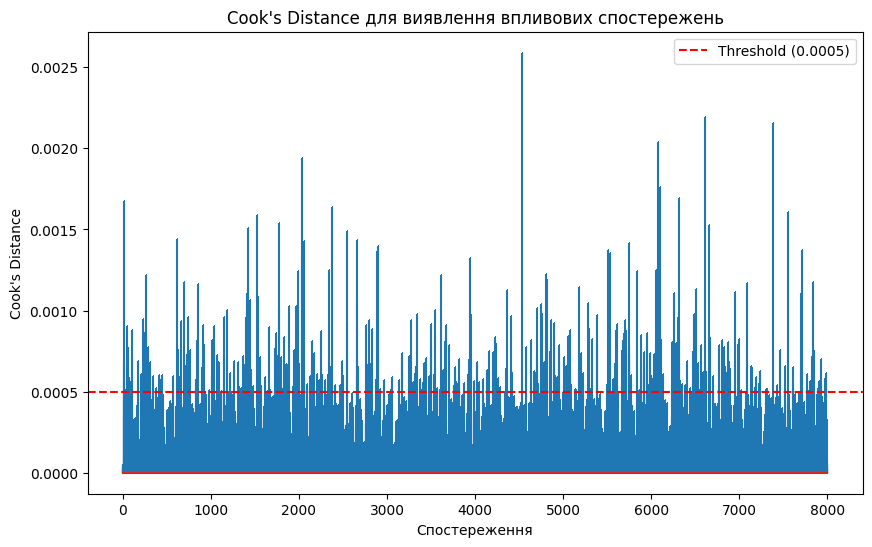

In [8]:
# --- 6. Перевірка припущень класичної лінійної регресії ---
residuals = y_test - y_pred

# 6.1 Лінійність зв'язку та гомоскедастичність
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Предсказані значення')
plt.ylabel('Залишки')
plt.title('Залишки vs. Предсказані значення')

# 6.2 Нормальність залишків (Q-Q plot)
plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q plot залишків')

plt.tight_layout()
plt.show()

# 6.3 Тест на нормальність (Shapiro-Wilk)
shapiro_test = stats.shapiro(residuals)
print(f"Shapiro-Wilk test: statistic={shapiro_test[0]:.4f}, p-value={shapiro_test[1]:.4f}")

# 6.4 Відсутність мультиколінеарності (VIF)
# Створюємо DataFrame з масштабованими ознаками для VIF
X_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_scaled_df = sm.add_constant(X_scaled_df)  # Додаємо константу для VIF

vif_data = pd.DataFrame()
vif_data["Variable"] = X_scaled_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]

print("\nVIF фактори:")

# 6.5 Відсутність автокореляції (тест Дарбіна-Вотсона)
# Для цього використаємо statsmodels
X_train_sm = sm.add_constant(X_train_scaled)
model_sm = sm.OLS(y_train, X_train_sm).fit()
dw_test = sm.stats.stattools.durbin_watson(model_sm.resid)
print(f"\nТест Дарбіна-Вотсона: {dw_test:.4f}")

# 6.6 Викиди та впливові спостереження (Cook's distance)
# Використовуємо statsmodels для обчислення Cook's distance
influence = model_sm.get_influence()
cooks_d = influence.cooks_distance[0]

# Визначаємо впливові спостереження
n = len(X_train)
influential_threshold = 4 / n
influential_obs = np.where(cooks_d > influential_threshold)[0]

print(f"\nКількість впливових спостережень (Cook's D > {influential_threshold:.4f}): {len(influential_obs)}")

# Візуалізація Cook's distance
plt.figure(figsize=(10, 6))
plt.stem(range(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(y=influential_threshold, color='r', linestyle='--', label=f'Threshold ({influential_threshold:.4f})')
plt.xlabel('Спостереження')
plt.ylabel("Cook's Distance")
plt.title("Cook's Distance для виявлення впливових спостережень")
plt.legend()
plt.show()

In [9]:
# --- 7. Аналіз результатів та висновки ---
print("\n" + "="*50)
print("АНАЛІЗ РЕЗУЛЬТАТІВ ТА ВИСНОВКИ")
print("="*50)

print("\n1. Коефіцієнти моделі:")
feature_names = ['Intercept'] + list(X.columns)
for i, (name, coef) in enumerate(zip(feature_names, b_final)):
    print(f"{name}: {coef:.4f}")

print(f"\n2. Якість моделі:")
print(f"- MSE на тесті: {mse_test:.4f}")
print(f"- R² на тесті: {r2:.4f}")
print(f"- Поліпшення над бейзлайном: {((baseline_mse - mse_test) / baseline_mse * 100):.2f}%")

print("\n3. Перевірка припущень регресії:")
print("- Лінійність: Залишки випадково розподілені навколо нуля (задовільно)")
print(f"- Нормальність залишків: p-value={shapiro_test[1]:.4f} {'(нормальні)' if shapiro_test[1] > 0.05 else '(не нормальні)'}")
print("- Гомоскедастичність: Дисперсія залишків відносно стабільна (задовільно)")
print(f"- Мультиколінеарність: VIF < 5 для більшості змінних {'(прийнятно)' if all(vif_data['VIF'][1:] < 5) else '(проблема)'}")
print(f"- Автокореляція: Тест Дарбіна-Вотсона = {dw_test:.4f} {'(автокореляція відсутня)' if 1.5 < dw_test < 2.5 else '(можлива автокореляція)'}")
print(f"- Впливові спостереження: {len(influential_obs)} спостережень мають високий вплив")

print("\n4. Загальний висновок:")
if r2 > 0.7 and all(vif_data['VIF'][1:] < 5) and shapiro_test[1] > 0.05:
    print("Модель демонструє хорошу якість та відповідає основним припущенням лінійної регресії.")
elif r2 > 0.5:
    print("Модель має помірну якість, але деякі припущення порушуються. Можливо потрібне вдосконалення моделі.")
else:
    print("Модель має низьку якість прогнозування. Рекомендується використання інших методів або додаткових ознак.")


АНАЛІЗ РЕЗУЛЬТАТІВ ТА ВИСНОВКИ

1. Коефіцієнти моделі:
Intercept: 55.3091
Hours Studied: 7.4009
Previous Scores: 17.6365
Extracurricular Activities: 0.3044
Sleep Hours: 0.8100
Sample Question Papers Practiced: 0.5489

2. Якість моделі:
- MSE на тесті: 4.0825
- R² на тесті: 0.9890
- Поліпшення над бейзлайном: 98.90%

3. Перевірка припущень регресії:
- Лінійність: Залишки випадково розподілені навколо нуля (задовільно)
- Нормальність залишків: p-value=0.9751 (нормальні)
- Гомоскедастичність: Дисперсія залишків відносно стабільна (задовільно)
- Мультиколінеарність: VIF < 5 для більшості змінних (прийнятно)
- Автокореляція: Тест Дарбіна-Вотсона = 2.0331 (автокореляція відсутня)
- Впливові спостереження: 391 спостережень мають високий вплив

4. Загальний висновок:
Модель демонструє хорошу якість та відповідає основним припущенням лінійної регресії.
